# Solutions `rasterio` & `atlite`

## Exercise 1: Land Exclusion Sensitivities

Tweak some parameters of the land exclusion calculation for wind deployment and observe the changes in available area and resulting wind power potential. For instance:

1. Vary the [CORINE land classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html),
2. Vary the buffer distance, for instance, to 0m or 2000m,
3. Add the [GEBCO topography data](https://www.gebco.net/) loaded at the beginning of the tutorial to the exclusion calculator and exclude areas above 1000m elevation.

Solution:

1. Change numbers in `codes_to_include` or `codes_to_exclude`. 
2. Change `buffer` keyword argument in `excluder.add_raster(..., buffer=2000)`.
3. Add line `excluder.add_raster(fn_to_gebco, crs=4326)`. The `crs=4326` is essential as data is given in another different projection.


## Exercise 2: Solar PV Orientation Sensitivities

The orientation of solar panels plays a decisive role in determining their potential power generation time series (as capacity factors using the `per_unit=True` keyword argument). Explore this aspect by performing the following sensitivity analysis on the solar PV setup for Portugal in January:

**Task 1:** Plot the total energy yield in January as a function of the slope of the panels oriented towards the South (0° means horizontal orientation, 90° means vertical orientation) in steps of 10°. What is the optimal tilt angle? Why might the value be higher than typically recommended for PV panels?

**Task 2:** Plot the power production profile for January 1 for the azimuth angles 0°, 90°, 180°, 270° of panels tilted at a 30° angle (i.e. varying north, east, south west orientations). What orientation does each angle represent? Describe the differences you observe.

**Task 3:** The `cutout.pv()` function can also consider multiple options for tracking features of solar panels as listed below. Tracking in solar panel systems refers to the mechanism that allows panels to move and orient themselves towards the sun, maximizing their exposure to sunlight and thereby increasing their electricity output. The default settings in `atlite` assume no tracking. Explore and describe the power output profile for different tracking options for January 31. How much more expensive in percent can the equipment for tracking be to achieve the same cost per unit of electricity produced as a fixed panel (if it only operated in January)?

Available tracking options in `atlite` are:

- `tracking='horizontal'` for 1-axis horizontal tracking: This setting positions solar panels to rotate around a horizontal axis, allowing them to follow the sun's path from east to west.
- `tracking='vertical'` for 1-axis vertical tracking: In this mode, the solar panels rotate around a vertical axis, which can be advantageous in high latitudes for better sun capture throughout the day.
- `tracking='dual'` for 2-axis tracking: This advanced system allows panels to track the sun both horizontally and vertically, maximizing solar exposure and energy capture throughout the day and year.

For all calculations, disregard land eligibility criteria and assume a uniform distribution of solar panels across Portugal.

In [ ]:
import atlite
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from os.path import basename

url = (
    "https://tubcloud.tu-berlin.de/s/2oogpgBfM5n4ssZ/download/PORTUGAL-2013-01-era5.nc"
)
urlretrieve(url, basename(url));

In [ ]:
cutout = atlite.Cutout("PORTUGAL-2013-01-era5.nc")

In [ ]:
url = "https://tubcloud.tu-berlin.de/s/7bpHrAkjMT3ADSr/download/country_shapes.geojson"
countries = gpd.read_file(url).set_index("name")
shapes = countries.loc[["PT"]].geometry

In [4]:
cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=shapes,
    per_unit=True,
).to_pandas

**Task 1 Solution:**

In [ ]:
kwargs = dict(
    panel="CSi",
    shapes=shapes,
    per_unit=True,
)

pv_orientation = {}
for slope in range(0, 100, 10):
    print(f"slope: {slope}°")
    pv_orientation[slope] = (
        cutout.pv(orientation=dict(slope=slope, azimuth=180.0), **kwargs)
        .to_pandas()
        .squeeze()
    )

df = pd.DataFrame(pv_orientation)

ax = df.mean().plot(
    ylabel="time-averaged capacity factor [per-unit]", xlabel="slope [°]"
)

ax.set_ylim(0, 0.13)

best = df.mean().idxmax()
print("The optimal slope is {:.0f}°".format(best))

**Task 2 Solution:**

In [ ]:
kwargs = dict(
    panel="CSi",
    shapes=shapes,
    per_unit=True,
)

pv_azimuth = {}
for angle in [0, 90, 180, 270]:  # North, East, South, West
    print(f"azimuth: {angle}°")
    pv_azimuth[angle] = (
        cutout.pv(orientation=dict(slope=30, azimuth=angle), **kwargs)
        .to_pandas()
        .squeeze()
    )

df = pd.DataFrame(pv_azimuth)

df.loc["2013-01-01"].plot(ylabel="capacity factor [per-unit]");

**Task 3 Solution:**

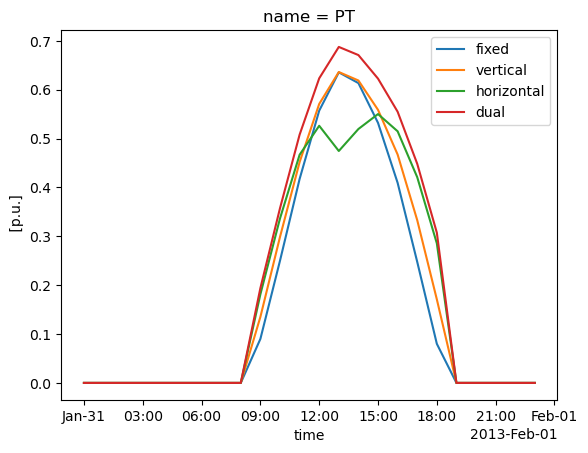

In [7]:
kwargs = dict(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    shapes=shapes,
    per_unit=True,
)

pv = cutout.pv(**kwargs)

pv_h = cutout.pv(tracking="horizontal", **kwargs)

pv_v = cutout.pv(tracking="vertical", **kwargs)

pv_d = cutout.pv(tracking="dual", **kwargs)

DAY = "2013-01-31"
fig, ax = plt.subplots()
pv.loc[DAY].plot(ax=ax, label="fixed")
pv_v.loc[DAY].plot(ax=ax, label="vertical")
pv_h.loc[DAY].plot(ax=ax, label="horizontal")
pv_d.loc[DAY].plot(ax=ax, label="dual")
plt.legend()